In [0]:
import numpy as np
from numpy import *
import cv2
import matplotlib.pyplot as plt
import numpy.linalg as linalg
import time
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def compute_root_mean_squared_error(b, theta1, theta2, data):
    total_error_x1 = 0
    total_error_x2 = 0
    for i in range(0, len(data)):
        x1 = data[i, 0]
        x2 = data[i, 1]
        y = data[i, 2]
        total_error_x1 += (y - (theta1 * x1 + b))**2
        total_error_x2 += (y - (theta2 * x2 + b))**2
        root_mean_squared_error_x1 = sqrt(total_error_x1 / float(len(data)))
        root_mean_squared_error_x2 = sqrt(total_error_x2 / float(len(data))) 
    return [root_mean_squared_error_x1, root_mean_squared_error_x2]

In [0]:
def step_gradient(data, current_b, current_theta1, current_theta2, learning_rate, num_iterations):
    b_gradient = 0
    theta1_gradient = 0
    theta2_gradient = 0
    N = float(len(data))

    for i in range(0, len(data)):
        x1 = data[i, 0]
        x2 = data[i, 1]
        y = data[i, 2]
        hypothesis = (current_theta1 * x1) + (current_theta2 * x2) + current_b
        b_gradient += y - hypothesis
        theta1_gradient += x1 * (y - hypothesis)
        theta2_gradient += x2 * (y - hypothesis)
    
    # weight update
    new_b = current_b - (learning_rate * (1/N) * b_gradient)
    new_theta1 = current_theta1 - (learning_rate * (1/N) * theta1_gradient)
    new_theta2 = current_theta2 - (learning_rate * (1/N) * theta2_gradient)
    return [new_b, new_theta1, new_theta2]
    
def run_gradient_descent(data, initial_b, initial_theta1, initial_theta2, learning_rate, num_iterations):
    """
    input the weights
    perform the weight update via step gradient
    """
    b = initial_b
    theta1 = initial_theta1
    theta2 = initial_theta2
    for i in range(num_iterations):
        b, theta1, theta2 = step_gradient(array(data), b, theta1, theta2, learning_rate, num_iterations)
    return [b, theta1, theta2]

In [0]:
def step_stochastic_gradient(data, current_b, current_theta1, current_theta2, learning_rate, num_iterations):
    b_gradient = 0
    theta1_gradient = 0
    theta2_gradient = 0
    N = float(len(data))
    for i in range(0, len(data)):
        x1 = data[i, 0]
        x2 = data[i, 1]
        y = data[i, 2]
        hypothesis = (current_theta1 * x1) + (current_theta2 * x2) + current_b
        b_gradient += y - hypothesis
        theta1_gradient += x1 * (y - hypothesis)
        theta2_gradient += x2 * (y - hypothesis)
    new_b = current_b - (learning_rate * b_gradient)
    new_theta1 = current_theta1 - (learning_rate * theta1_gradient)
    new_theta2 = current_theta2 - (learning_rate * theta2_gradient)
    return [new_b, new_theta1, new_theta2]

def run_stochastic_gradient_descent(data, initial_b, initial_theta1, initial_theta2, learning_rate, num_iterations):
    # preprocessing
    np.random.shuffle(data)
    
    b = initial_b
    theta1 = initial_theta1
    theta2 = initial_theta2
    for i in range(num_iterations):
        b, theta1, theta2 = step_stochastic_gradient(array(data), b, theta1, theta2, learning_rate, num_iterations)
    return [b, theta1, theta2]

In [0]:
def softMaxRMSProp(self, dL_dout, learning_rate):

    for i, grad in enumerate(dL_dout):
      if grad == 0:
        continue
    
      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      # Gradients w/ respect to output (z)
      dy_dz = -transformation_eq[i]*transformation_eq / (S_total ** 2)
      dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total ** 2)

      # Gradients of totals against weights/biases/input
      dz_dw = self.modified_input # against weights
      dz_db = 1 # against biases
      dz_d_inp = self.weight # against input

      # Gradients of loss against totals
      dL_dz = grad * dy_dz

      # Gradients of loss against weights/biases/input
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis] # against weights (@ => matrix multiplication operator)
      dL_db = dL_dz * dz_db # against biases
      dL_d_inp = dz_d_inp @ dL_dz # against input

      # Update weights and biases
      beta = 0.9
      movingAverage_w = beta*linalg.norm(dL_d_inp)+(1-beta)*np.square(dL_dw)
      self.weight -= learning_rate/np.sqrt(movingAverage_w)*dL_dw
      movingAverage_b = beta*linalg.norm(dL_d_inp)+(1-beta)*np.square(dL_db)
      self.bias -= learning_rate/np.sqrt(movingAverage_b)*dL_db

    return dL_d_inp.reshape(self.orig_image_shape)

In [0]:
def convRMSProp(self, dL_dout, learning_rate):
    dL_dF_params = np.zeros(self.conv_filter.shape)

    # need to vectorize this
    for image_patch, i, j in self.image_region(self.image):
      for k in range(self.num_filters):
        dL_dF_params[k] += image_patch * dL_dout[i,j,k]
    
    # weight update (gradient descent) - this should be configurable to any optimizer
    beta = 0.9
    movingAverage_w = beta*linalg.norm(dL_dout)+(1-beta)*np.square(dL_dF_params)
    self.conv_filter -= learning_rate * np.sqrt(movingAverage_w)*dL_dF_params
    return dL_dF_params

In [0]:
def run():
    # load data
    training_data_filename = 'training-data.csv'
    testing_data_filename = 'testing-data.csv'
    training_data = genfromtxt(training_data_filename, delimiter=',')
    testing_data = genfromtxt(testing_data_filename, delimiter=',')
        
    num_iterations = 1000
    
    # hyperparameters
    learning_rate = 0.000001
    decay_factor = 0.9 # set between 0.5 and 0.9
    
    # learned parameters
    initial_vb = 0
    initial_v1 = 0
    initial_v2 = 0
    initial_b = 0
    initial_theta1 = 0
    initial_theta2 = 0

    # GD
    print('########### multivariate GRADIENT DESCENT algorithm for linear regression ###########')
    [train_b_gd, train_theta1_gd, train_theta2_gd] = run_gradient_descent(training_data, initial_b, initial_theta1, initial_theta2, learning_rate, num_iterations)
    [test_b_gd, test_theta1_gd, test_theta2_gd] = run_gradient_descent(testing_data, initial_b, initial_theta1, initial_theta2, learning_rate, num_iterations)

    train_error_gd = compute_root_mean_squared_error(train_b_gd, train_theta1_gd, train_theta2_gd, training_data)
    test_error_gd = compute_root_mean_squared_error(test_b_gd, test_theta1_gd, test_theta2_gd, testing_data)
    
    print('RMSE on training set [THETA_1, THETA_2]:{}'.format(train_error_gd))
    print('RMSE on test set [THETA_1, THETA_2]:{}'.format(test_error_gd))
    print('\n')

    # SGD
    print('########### multivariate SGD algorithm for linear regression ###########')
    [train_b_sgd, train_theta1_sgd, train_theta2_sgd] = run_stochastic_gradient_descent(training_data, initial_b, initial_theta1, initial_theta2, learning_rate, num_iterations)
    [test_b_sgd, test_theta1_sgd, test_theta2_sgd] = run_stochastic_gradient_descent(testing_data, initial_b, initial_theta1, initial_theta2, learning_rate, num_iterations)
  
    train_error_sgd = compute_root_mean_squared_error(train_b_sgd, train_theta1_sgd, train_theta2_sgd, training_data)
    test_error_sgd = compute_root_mean_squared_error(test_b_sgd, test_theta1_sgd, test_theta2_sgd, testing_data)
    
    print('RMSE on training set [THETA_1, THETA_2]:{}'.format(train_error_sgd))
    print('RMSE on test set [THETA_1, THETA_2]:{}'.format(test_error_sgd))
    print('\n')

CNN CODE

In [0]:
class Conv:
  def __init__(self, num_filters, filter_size):
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size * filter_size) # normalize the values

  def image_region(self, image):
    # generator function
    height, width = image.shape
    self.image = image

    # need to vectorize this
    for i in range (height - self.filter_size + 1):
      for j in range (width - self.filter_size + 1):
        image_patch = image [i: (i + self.filter_size), j: (j + self.filter_size)]
        yield image_patch, i, j # stores all image patches
  
  def forward_prop(self, image):
    height, width = image.shape
    conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters))
    
    # need to vectorize this
    for image_patch, i, j in self.image_region(image):
      conv_out[i, j] = np.sum(image_patch * self.conv_filter, axis = (1, 2))
    return conv_out

  def back_prop(self, dL_dout, learning_rate):

    return convRMSProp(self, dL_dout, learning_rate)

In [0]:
class Max_Pool:
  def __init__(self, filter_size):
    self.filter_size = filter_size
  
  def image_region(self, image):
    new_height = image.shape[0] // self.filter_size
    new_width = image.shape[1] // self.filter_size
    self.image = image

    # need to vectorize this
    for i in range(new_height):
      for j in range(new_width):
        image_patch = image[(i*self.filter_size) : (i*self.filter_size + self.filter_size) , (j*self.filter_size) : (j*self.filter_size + self.filter_size)]
        yield image_patch, i, j

  def forward_prop(self, image):
    height, width, num_filters = image.shape
    output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

    # need to vectorize this
    for image_patch, i, j in self.image_region(image):
      output[i, j] = np.amax(image_patch, axis=(0,1))

    return output 
  
  def back_prop(self, dL_dout):
    dL_dmax_pool = np.zeros(self.image.shape)
    for image_patch, i, j in self.image_region(self.image):
      height, width, num_filters = image_patch.shape
      maximum_val = np.amax(image_patch, axis=(0,1))

      # need to vectorize this 
      for i1 in range(height):
        for j1 in range(width):
          for k1 in range(num_filters):
            if image_patch[i1, j1, k1] == maximum_val[k1]:
              dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1, k1] = dL_dout[i, j, k1]
      
      return dL_dmax_pool  

In [0]:
class SoftMax:
  def __init__(self, input_node, softmax_node):
    self.weight = np.random.randn(input_node, softmax_node) / input_node
    self.bias = np.zeros(softmax_node)

  def forward_prop(self, image):
    self.orig_image_shape = image.shape
    modified_image = image.flatten()
    self.modified_input = modified_image
    output_val = np.dot(modified_image, self.weight) + self.bias
    self.out = output_val
    exp_out = np.exp(output_val)
    return exp_out/np.sum(exp_out, axis = 0)

  def back_prop(self, dL_dout, learning_rate):

    """
    add input parameter called optimizer w/ values ('gd', 'sgd', 'sgd_mom', 'sgd_nesterov', 'adam', 'rmsprop', etc...)
    check optimizer param against the input string and run the appropriate algorithm
    should be consistent w/ the value passed to the conv layer

    if optimizer == 'gd':
      run_gd()
    
    if optimizer == 'sgd':
      run_sgd()

    ...
    """

    #   return dL_d_inp.reshape(self.orig_image_shape)
    return softMaxRMSProp(self, dL_dout, learning_rate)

In [0]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_images = X_train[:6000]
train_labels = y_train[:6000]
test_images = X_test[:1500]
test_labels = y_test[:1500]

conv = Conv(8, 3)
pool = Max_Pool(2)
softmax = SoftMax(13 * 13 * 8, 10)
"""
class CNN:
  def __init__(self, )
"""

def feed_forward(image, label):
  out = conv.forward_prop((image / 255) - 0.5)
  out = pool.forward_prop(out)
  out = softmax.forward_prop(out)

  # Calculate cross-entropy loss and accuracy
  cross_entropy_loss = -np.log(out[label])
  accuracy = 1 if np.argmax(out) == label else 0

  return out, cross_entropy_loss, accuracy

def train(image, label, learning_rate = 0.0001):

  # Forward
  out, loss, acc = feed_forward(image, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  # Backpropagation
  grad_back = softmax.back_prop(gradient, learning_rate)
  grad_back = pool.back_prop(grad_back)
  grad_back = conv.back_prop(grad_back, learning_rate)

  return loss, acc

In [0]:
print('Training the CNN....')
start_time = time.clock()
loss = 0
num_correct = 0
lossVals = []
accuVals = []
for epoch in range(10):
  print('Epoch %d ----> ' % (epoch + 1))

  # Shuffle the training data
  shuffle_data = np.random.permutation(len(train_images))
  train_images = train_images[shuffle_data]
  train_labels = train_labels[shuffle_data]

  # Train the CNN
  for i, (img, label) in enumerate(zip(train_images, train_labels)):
    # print progress every 100 images 
    if i % 100 == 0:
      print('%d of 100 steps: Average loss %.3f and Accuracy: %d%%' % (i + 1, loss / ((i + 1) + epoch*6000), (num_correct * 100 / ((i + 1) + epoch*6000))))

    l1, accu = train(img, label)
    lossVals.append(loss / ((i + 1) + epoch*6000))
    accuVals.append(num_correct * 100 / ((i + 1) + epoch*6000))

    loss += l1
    num_correct += accu

Training the CNN....
Epoch 1 ----> 
1 of 100 steps: Average loss 0.000 and Accuracy: 0%
101 of 100 steps: Average loss 2.262 and Accuracy: 23%
201 of 100 steps: Average loss 2.275 and Accuracy: 19%
301 of 100 steps: Average loss 2.277 and Accuracy: 19%
401 of 100 steps: Average loss 2.269 and Accuracy: 22%
501 of 100 steps: Average loss 2.264 and Accuracy: 23%
601 of 100 steps: Average loss 2.259 and Accuracy: 25%
701 of 100 steps: Average loss 2.256 and Accuracy: 26%
801 of 100 steps: Average loss 2.253 and Accuracy: 28%
901 of 100 steps: Average loss 2.247 and Accuracy: 31%
1001 of 100 steps: Average loss 2.242 and Accuracy: 33%
1101 of 100 steps: Average loss 2.235 and Accuracy: 35%
1201 of 100 steps: Average loss 2.230 and Accuracy: 36%
1301 of 100 steps: Average loss 2.226 and Accuracy: 37%
1401 of 100 steps: Average loss 2.223 and Accuracy: 38%
1501 of 100 steps: Average loss 2.219 and Accuracy: 40%
1601 of 100 steps: Average loss 2.216 and Accuracy: 41%
1701 of 100 steps: Averag

In [0]:
# Test the CNN
print('Testing the CNN....')
start = time.clock()
test_lossVals = []
test_accuVals = []
loss = 0 
num_correct = 0
for i, (img, label) in enumerate(zip(test_images, test_labels)):
  _, l1, accu = feed_forward(img, label)
  loss += l1
  num_correct += accu
  test_lossVals.append(loss / (i+1))
  test_accuVals.append((num_correct * 100) / (i+1))

num_tests = len(test_images)
print('Test loss: ', loss / num_tests)
print('Test accuracy: ', num_correct / num_tests)
print(time.clock() - start)

Testing the CNN....
Test loss:  1.2268963194023852
Test accuracy:  0.7413333333333333
28.645920999999362


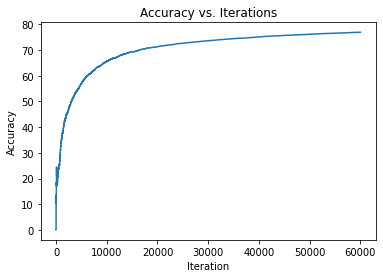

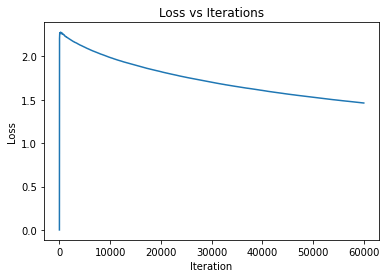

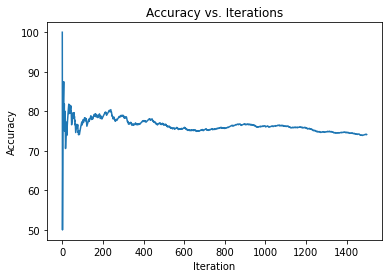

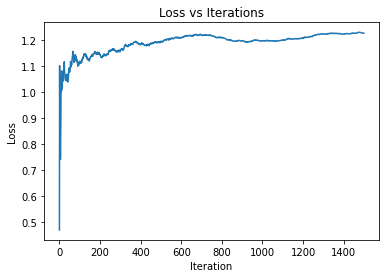

In [0]:
plt.plot(accuVals)
plt.title("Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

plt.plot(lossVals)
plt.title("Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# Plots for testing

plt.plot(test_accuVals)
plt.title("Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

plt.plot(test_lossVals)
plt.title("Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [0]:
# Add a file called accu_loss.csv into google colab's files

import csv

with open('rmsprop-training-0001.csv', mode='w') as accu_loss:
    accu_loss_writer = csv.writer(accu_loss, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for accu, loss in zip(accuVals, lossVals):
      accu_loss_writer.writerow([accu, loss])

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Add a file called accu_loss.csv into google colab's files
# Save testing accuracies and loss

import csv

with open('rmsprop-testing-0001.csv', mode='w') as accu_loss:
    accu_loss_writer = csv.writer(accu_loss, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for accu, loss in zip(test_accuVals, test_lossVals):
      accu_loss_writer.writerow([accu, loss])

print ("Finished writing")

Finished writing
